# How Racial Capitalism Persits today in Lexington, KY
## An exploration of 1930s Redlining Practices
This notebook covers the steps taken to collect and pre-process data for redlining-wealth-health-lexington github repo.

#### Table of Contents  
 - [Dependencies](#dependencies)
 - [Intro to US Census Bureau Data](#introUSCB)
 - [Intro to Lexington's Data Portal](#introLexData)
 - [Data Used](#dataStart)
 - [Inspiration for Maps](#inspiration)
 - [End of Day Thoughts](#endOfDay)
 - [Exploring Data Sets](#dataExplore)
     - [Race/Segregation Data](#raceSegregation)
         - [Drop a Feature/Column](#dropFeature)
         - [Rename Columns & Remove Row Identifier](#rename)
     - [Census Bureau Tract Data 2019](#cbtract)
     - [Merge Race/Segregation Data & Census Bureau Tract Data](mergeRaceTract)
         - [Map Race/Segregation Data](#mapRaceTract)
             - [Clipping to New Circle](#newCircle)
             - [Clip by HOLC neighborhoods](#clipHOLC)

<a id='dependencies'></a>
## Dependencies

Required environment dependencies (actually loaded into environment):  
**jupyter notebook** conda install -c conda-forge jupyter  
**numpy** conda install -c conda-forge numpy  
**geopandas** conda install --channel conda-forge geopandas  
**pandas** (version 0.24 or later) conda install -c conda-forge pandas  
**shapely** (interface to GEOS) conda install -c conda-forge shapely  
**fiona** (interface to GDAL) conda install -c conda-forge fiona  
**matplotlib** (>=2.2.0) conda install -c conda-forge matplotlib  
**pyproj** (interface to PROJ; version 2.2.0 or later) conda install -c conda-forge pyproj

Further, optional dependencies (actually loaded into environment:  
**rtree** (optional; spatial index to improve performance and required for overlay operations; interface to libspatialindex) conda install -c conda-forge rtree  
**psycopg2**(optional; for PostGIS connection) conda install -c conda-forge psycopg2  
**GeoAlchemy2** (optional; for writing to PostGIS)conda install -c conda-forge geoalchemy2  
**geopy** (optional; for geocoding) conda install -c conda-forge geopy  

For plotting, these additional packages may be used:  
**mapclassify**(>=2.2.0)  

<a id='introUSCB'></a>
## Intro to US Census Bureau Data 
[Video](https://www.youtube.com/watch?v=1LZPYS0cR68) detailing how to access data for specific census tracts.  
Can find US Census data [here](https://mtgis-portal.geo.census.gov/arcgis/apps/MapSeries/index.html?appid=2566121a73de463995ed2b2fd7ff6eb7) on the 2020 Census Bureau Demographic Data Map Viewer OR [here](data.census.gov)

#### Data Hierarchy
Data within the US Census bureau is organized in a hierarchy of:
Nation-> State -> County -> Tract -> Block Group -> Block
Where a Nation is composed of many states which are composed of many counties etc..

Will need to use these sites to determine the exact census tracts for data interested in. 
Will most likely need use the tract name to merge or join tables.

[Census tracts and tract codes](https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf)
[GEOIDS Specifics](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html)
- The decimal point separating the 4-digit basic tract code from the 2-digit suffix is shown in US Census Bureau printed reports and maps. However, in computer-readable files prepared by the Census Bureau decimal point is implied and does not appear. 
- A census tract code may not be used more than once in a single county, but it may be used again in a different county in the same state or in a county in a different state. Therefore must be identified by: its state, its county, and its tract code. 
- 11-digit code consisting of 
    - 2 digits for state (FIPS code)
    - 3 digits for county (FIPS code)
    - 6 digits for census tract 
    - All may have one or more leading 0's and two trailing 0's



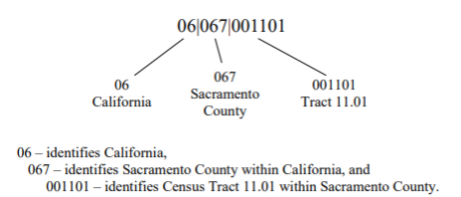

#### Where to find data
If using **data.census.gov**  
From here site click *advanced search* and select what filters to work through.  
This section of the site is great for a gui that allows you to quickly visualize data attribute tables and polygons on a map.

Geography example:  
Click advanced search-geography filter-select the hierarchy level wish to pull-state-county-within (tract)  
To only pull data from 2020 census click on year filter and select year of interest  
To only pull data from specific census click on surveys filter and select survey of interest  
Click search (data tables resulting from these filters will populate)  
Can then either download the table in csv or look in map format  

For example I chose  
advanced search-geography-block-kentucky-fayette-all blocks within fayette county  

Another option (great for knowing specific topic of interest but not the name of the precise survey needed to view in gui from above site.) use **census.gov/data.html**  
From here click browse by topic, search in search bar with simple terms to find correct abbreviation of interest then return to data.census.gov and search for abbreviation of interest (example: DP04 or S1901) and refine as described above.  

#### Promising Surveys  
**DP4 Profile of Selected Housing Characteristics: 2000** Decennial Survey (since this is older data will try to utilize DP04 instead).  
**DP04 Selected Housing Characteristics (2019: ACS American Community Survey 5 year estimates data profiles**   
Housing units, Structure type, year built, number of rooms, year householder moved into unit (establish long term owners), vehicles, house heating, *specified owner occupying units value vs renter units*, *value owner-occupied units*, *gross rent*, *gross rent as % of household income*  
**DP02 Selected Social Characteristics in the United States (2019: ACS 5-Year Estimates Data Profiles**  
Educational attainment, Disability status, residence length, with a computer, with broadband internet
**S1701 Poverty Status in the past 12 months (ACS)**  
Estimate of total number of people for whom poverty status was determined (poverty or not) with below poverty level numbers calculated per census tract.  
**S1901 Income in the past 12 months (in 2019 inflation-adjusted dollars)**  
Household income range, Median income  

<a id='introLexData'></a>
## Intro to Lexington's Data Portal
Lexington has some data already configured in their own archub data portal gui to demo files from some census tract work and past work provided by other private uploaders to the site. Some potential data sets of interest to begin with are below. If I persue further information regaring health or access to certain spaces I may return to this data. Currently looking to pull most data from Census Bureau.
https://data-lfucg.hub.arcgis.com/

**GOOD DATA FILE for neighborhoods but no common ground to merge.**
Census 2020 by Race for 18 and Over by Preceinct in geoJSON format accessed 1/27/2022 from [here](https://data-lfucg.hub.arcgis.com/datasets/a1e93b1a225a4bb79baa00190e2b212c_0/explore?location=38.029745%2C-84.464568%2C13.69)

This is an alternative option to finding census tracts as they should be included in this geojson from 2020 census.
This data set containes the names of the neighborhoods.
This data set also uses a unique change in identification. In 2020 there was an option to identify as more than one race (multiracial). Will need to consider this when exploring the race make up of the precincts. Can use the dominate identifiers or be more specific i.e. white vs black or african american vs *race 1 and race 2*

Would like to know what CODE stands for, example CODE C129 and NAME IDLE HOUR. is C129 part of a precinct number? 

[**GOOD DATA FILE for Census Tracts 2010**](https://data-lfucg.hub.arcgis.com/datasets/6cb9e8be350d45d19f1e517d2e9c4e4b_0/explore?location=38.041424%2C-84.451398%2C12.05) Good example of tract number identification from 2010 census tracts.
It would appear **NAME10** on Census Tract 2010 corresponds to **BASENAME** for Census Tract in US Census Bureau 2019 census. Caveat in using this data is it's dated. Should find more up to date data file.

[**GOOD DATA FILE for Census Tracts & Race**](https://data-lfucg.hub.arcgis.com/datasets/8c1d1363e6ce4822b818a51469f4f502_0/explore)
Census 2020 Precinct_p1_race

[**GOOD DATA FILE for Landuse (Vacancies)**](https://data-lfucg.hub.arcgis.com/datasets/8113df2403c048a0837a0bec68906f3a_0/explore?filters=eyJMVTIwMDUiOlsiU0YiLCJNRiIsIkQiLCJDT00iLCJWQUMiXX0%3D&location=38.031300%2C-84.466517%2C13.19)
Only issue is that the landuse may be from 2005.

[**Good DATA FILE for Parks**](https://data-lfucg.hub.arcgis.com/datasets/764044274e974dbba9069d9dab7dcb34_0/explore?location=38.037063%2C-84.482212%2C13.06)
Park type, acreage. Need to check and see if this is more up to date than the previous park project completed in lex_redlined_and_parks personal repo

[**Property values Option B**](https://qpublic.schneidercorp.com/Application.aspx?AppID=1019&LayerID=21445&PageTypeID=4&PageID=9143&Q=1076636217&KeyValue=40100350)
allowed 100 free look ups first month
each additional month 50 free look ups.
could limit the look ups to one holc a and one holc d? 

[**Occupancy Status by Precinct Census 2020**](https://data-lfucg.hub.arcgis.com/datasets/4ce0a61b95764366a1971f5960a10690_0/explore?location=38.028065%2C-84.471929%2C13.69)
Occupied vs vacant reported properties

[**Greenway**](https://data-lfucg.hub.arcgis.com/datasets/79605c14aebf4bbb98c6df79c6e539ec_0/explore?location=38.022719%2C-84.458785%2C16.91)
acreage of greenspace 

[**Railway**](https://data-lfucg.hub.arcgis.com/datasets/7671e2d17391430ebca3e88e547a0cb0_0/explore?location=38.056548%2C-84.478677%2C13.08)
line work for railways in lex

Impervious Area 2007 (private upload can download as shapefile)
Tree Canopy (private upload can download as shapefile)

Other data sets of interest for another day:
Various school zones (districts?)
Library
Bicycle Network

<a id='dataStart'></a>
## Data Used
It does appear the US Census Bureau will be releasing their 2020 data come Mid March. Possible idea would be to revisit this project with updated data come April.

#### Links to Data
- Census Bureau Census Tract
    - [2019 Shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2019.html)
        - Shapefile
        - 2.27 MB
        - Accessed 13 February 2022
        - [Glossary](https://www2.census.gov/geo/tiger/GENZ2019/2019_file_name_def.pdf?#)
    - [2020 Shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) If end up coming back for 2020 data
- HOLC Graded Neighborhood Polygons
    - [Mapping Inequality Redlining in New Deal America](https://dsl.richmond.edu/panorama/redlining/#loc=14/38.041/-84.526&city=lexington-ky&text=downloads)
        - Shapefile or GeoJSON
        - Georectified Image
        - Scan jpg
        - Citation: Robert K. Nelson, LaDale Winling, Richard Marciano, Nathan Connolly, et al., “Mapping Inequality,” American Panorama, ed. Robert K. Nelson and Edward L. Ayers, accessed February 2, 2022, https://dsl.richmond.edu/panorama/redlining/#loc=14/38.041/-84.526&city=lexington-ky&text=downloads.
- Race/Segregation 
    - [*Race for the Population 18 years+ 2020*](https://data.census.gov/cedsci/table?q=p3&t=Race%20and%20Ethnicity&g=0500000US21067%241400000&y=2020)
    - Data available to download in:
        - CSV metadata
        - CSV file data
        - TXT file table title
        - Accessed: 8 Feb 2022
        - Citation:
        - Notes: Census Data utilized was for those identifying as a Population of one race. Options to declare included White alone, Black or African American alone, American Indian and Alaska Native alone, Asian alone, Native Hawaiian and Other Pacific Islander Alone, Some Other Race alone. Additional options existed to self declare population of 2 or more races. Only selected data for populations identifying as a single race either White alone OR Black or African American alone. This was selected as identifying as a single race white or Black was the purpose of exploration in relation to HOLC 1930s neighborhood identifications.
- Median Household income
    - [*S1901 Income in the past 12 months (in 2019 inflation-adjusted dollars)*](https://data.census.gov/cedsci/table?q=income&g=0500000US21067%241400000&y=2019)
    - CSV file type includes: 
        - CSV file metadata
        - CSV file data
        - TXT file table title
        - 19.4 kb
        - Accessed: 
        - Citation:
- % of population in poverty 
    - [*S1701 Poverty Status in the past 12 months (ACS)*](https://data.census.gov/cedsci/table?q=s1701&g=0500000US21067%241400000&y=2019)
    - [Symbols](https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-pov/pov-01.2019.html#par_textimage_9999998) used in tables: 
        - (B) Base less than 75,000
        - (X) Estimate is not applicabple or not available
        - (Z) Rounds to zero
    - CSV File type includes:
        - CSV File Metadata
        - CSV file data
        - TXT file table title
        - 59.7 kb
        - Accessed: 
        - Citation: 
- Mortgage approval rates through time (HMDA home mortgage disclosure act data, by census tract number, race of applicant, not sure if approvals/denials within large data set too large to open in excel)
    - ?????????
- Census Tracts for mapping!!!!
    - ?????????
- Percent homeownership today 
    - [*US census bureau American Community Survey DP04 2019*](https://data.census.gov/cedsci/table?q=DP04&g=0500000US21067%241400000)
    - CSV File type includes:
        - CSV file metadata
        - CSV file data
        - TXT file table title
        - 88.5 kb
        - Accessed: 
        - Citation:
- Property values today
    - [*US census bureau American Community Survey DP04 2019*](https://data.census.gov/cedsci/table?q=DP04&g=0500000US21067%241400000) has owner reported value of house in range
    - CSV File type includes:
        - CSV file metadate
        - CSV file data
        - TXT file table title
        - 88.5 kb (but will have already downloaded for percent ownership today)
        - Accessed:
        - Citation:
- Quality of property 
    - NLCD Tree Land Cover data set? or tree coverage from lex
    - impervious surface coverage from LEX
    - distance to park (ref previous project)
    - vacant lots nearby
    - nearby railroad
- Timeline (Journal articles to reference history and development of Lexington)
    - May use images from journal articles for demo. Articles of interest:
        - Kellogg, John. 1982. The Formation of Black Residential Areas in Lexington, Kentucky 1865-1887. Southern Historical Association. Vol 48. No 1. pp. 21-52.
        - O'Malley, Nancy. 2002. The Pursuit of Freedom The Evolution of Kinkeadtown, an African American Post-Civil War Neighborhood in Lexington, Kentucky. Winterthur Portfolio. Vol 37. No. 4. pp. 187-218.
        - Rabinowitz, Howard. 1976. From Reconstruction to Redemption in the Urban South. Journal of Urban History. Vol 2. No 2. pp 169-194
        - Kellogg, John. 1977. Negro Urban Clusters in the Posbellum South. Geographical Review. Vol 67. No 3. pp. 310-321.
        - Kendi, Ibram. 2016. Stamped from the Beginning The Definitive History of Racist Ideas in America. New York, Bold Type Books. pp 583. 


<a id='inspiration'></a>
## Inspiration for Maps
- [ramp styling 2020 census by race](https://mtgis-portal.geo.census.gov/arcgis/apps/MapSeries/index.html?appid=2566121a73de463995ed2b2fd7ff6eb7)
- [overalp of holc designations & secondary ramp map](https://mtgis-portal.geo.census.gov/arcgis/apps/MapSeries/index.html?appid=2566121a73de463995ed2b2fd7ff6eb7)

<a id='endOfDay'></a>
### End of Day Thoughts:
Items to consider at a later date.
*Determine what years data is available for interest, then select correct census tract that best corresponds to these. (It appears the latest data is 2019 with the exception that come Mid March new 2020 census data will be released from US Census Bureau)
*Would be interesting to look at impervious surfaces vs tree canopy as a way to analyse simple pleasure of green. look for the demarcation of affluent areas by satellite? or aerial imagery (inspiration Bunge 2011 from map719) green grass on a colored aerial photograph almost perfectly maps the territory of the affluent-their campuses, expressways, downtown business center, parks, and homes. The affluent are surrounded by private parks.   

<a id='dataExplore'></a>
# Exploring Data Sets

In [2]:
# load require packages for exploring spatial data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a id='raceSegregation'></a>
## Race/Segregation Data

In [3]:
# Load CSV data as pandas DataFrame
race_df = pd.read_csv('./data/race_pop_18up_2020.csv')

In [4]:
#Verify race_df now references pandas DataFrame object, not CSV file
type(race_df)

pandas.core.frame.DataFrame

In [5]:
# get an idea for starting place of information
race_df.info()

#83 individual entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 73 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   GEO_ID   83 non-null     object
 1   NAME     83 non-null     object
 2   P3_001N  83 non-null     object
 3   P3_002N  83 non-null     object
 4   P3_003N  83 non-null     object
 5   P3_004N  83 non-null     object
 6   P3_005N  83 non-null     object
 7   P3_006N  83 non-null     object
 8   P3_007N  83 non-null     object
 9   P3_008N  83 non-null     object
 10  P3_009N  83 non-null     object
 11  P3_010N  83 non-null     object
 12  P3_011N  83 non-null     object
 13  P3_012N  83 non-null     object
 14  P3_013N  83 non-null     object
 15  P3_014N  83 non-null     object
 16  P3_015N  83 non-null     object
 17  P3_016N  83 non-null     object
 18  P3_017N  83 non-null     object
 19  P3_018N  83 non-null     object
 20  P3_019N  83 non-null     object
 21  P3_020N  83 non-null     object
 22  P3_0

View first 5 rows

In [6]:
# Initial Look at data with first 5 rows
race_df.head(5)

,GEO_ID,NAME,P3_001N,P3_002N,P3_003N,P3_004N,P3_005N,P3_006N,P3_007N,P3_008N,...,P3_062N,P3_063N,P3_064N,P3_065N,P3_066N,P3_067N,P3_068N,P3_069N,P3_070N,P3_071N
0,id,Geographic Area Name,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or A...,!!Total:!!Population of one race:!!American I...,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Haw...,!!Total:!!Population of one race:!!Some Other...,...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...
1,1400000US21067000101,"Census Tract 1.01, Fayette County, Kentucky",2781,2562,1916,492,17,70,2,65,...,0,0,0,0,0,0,0,0,0,0
2,1400000US21067000102,"Census Tract 1.02, Fayette County, Kentucky",1339,1280,991,262,4,14,0,9,...,0,0,0,0,0,0,0,0,0,0
3,1400000US21067000200,"Census Tract 2, Fayette County, Kentucky",2709,2594,1790,708,5,22,2,67,...,0,0,0,0,0,0,0,0,0,0
4,1400000US21067000300,"Census Tract 3, Fayette County, Kentucky",2227,2058,971,1004,13,5,0,65,...,0,0,0,0,0,0,0,0,0,0


See all column headers

In [7]:
# Confirm seeing all columns
pd.options.display.max_columns = None
# Initial Look at data
race_df.head(5)

,GEO_ID,NAME,P3_001N,P3_002N,P3_003N,P3_004N,P3_005N,P3_006N,P3_007N,P3_008N,P3_009N,P3_010N,P3_011N,P3_012N,P3_013N,P3_014N,P3_015N,P3_016N,P3_017N,P3_018N,P3_019N,P3_020N,P3_021N,P3_022N,P3_023N,P3_024N,P3_025N,P3_026N,P3_027N,P3_028N,P3_029N,P3_030N,P3_031N,P3_032N,P3_033N,P3_034N,P3_035N,P3_036N,P3_037N,P3_038N,P3_039N,P3_040N,P3_041N,P3_042N,P3_043N,P3_044N,P3_045N,P3_046N,P3_047N,P3_048N,P3_049N,P3_050N,P3_051N,P3_052N,P3_053N,P3_054N,P3_055N,P3_056N,P3_057N,P3_058N,P3_059N,P3_060N,P3_061N,P3_062N,P3_063N,P3_064N,P3_065N,P3_066N,P3_067N,P3_068N,P3_069N,P3_070N,P3_071N
0,id,Geographic Area Name,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or A...,!!Total:!!Population of one race:!!American I...,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Haw...,!!Total:!!Population of one race:!!Some Other...,!!Total:!!Population of two or more races:,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two or more races:!!P...,!!Total:!!Population of two 

In first glance we won't need all of the columns within the dataframe. 
- Need to reduce to only those of interest. 
    - Keep the following (and rename):
        - Total = **P3_001N**
        - Total: Population of one Race: White alone = **P3_003N**
        - Total: Population of one Race: Black or African American alone = **P3_004N**
    - Drop the following:
        - **P3_002N, P3_005N:P3_071N**
- Will also need to include a note in analysis that all other races were not considered as this was an exploration only of the White and Black populations (represented as a single race). Prior to 2020 I don't believe multiple race identification was included on the census?
- Need to reduce to only census tracts of interest, though this may be easier accomplished once mapped to know which to keep.

<a id='dropFeature'></a>
### Drop a Feature/Column
Drop attributes/columns that are unnecesssary to reduce size and make more legible.

In [8]:
# To Drop Columns
to_drop = ['P3_002N', 'P3_005N', 'P3_006N','P3_007N','P3_008N','P3_009N','P3_010N','P3_011N','P3_012N','P3_013N','P3_014N',
          'P3_015N','P3_016N','P3_017N','P3_018N', 'P3_019N', 'P3_020N', 'P3_021N', 'P3_022N', 'P3_023N', 'P3_024N', 'P3_025N',
          'P3_026N', 'P3_027N','P3_028N', 'P3_029N', 'P3_030N', 'P3_031N', 'P3_032N', 'P3_033N', 'P3_034N', 'P3_035N',
          'P3_036N', 'P3_037N','P3_038N', 'P3_039N', 'P3_040N', 'P3_041N', 'P3_042N', 'P3_043N', 'P3_044N', 'P3_045N',
          'P3_046N', 'P3_047N','P3_048N', 'P3_049N', 'P3_050N', 'P3_051N', 'P3_052N', 'P3_053N', 'P3_054N', 'P3_055N',
          'P3_056N', 'P3_057N','P3_058N', 'P3_059N', 'P3_060N', 'P3_061N', 'P3_062N', 'P3_063N', 'P3_064N', 'P3_065N',
          'P3_066N', 'P3_067N','P3_068N', 'P3_069N', 'P3_070N', 'P3_071N' ] #columns to drop

# drop excess columns from dataframe
# assign remaining data to new dataframe name
race_bw_df = race_df.drop(to_drop, axis=1)


Confirm drop

In [9]:
# Confirm column/feature drops
race_bw_df.head(5)

,GEO_ID,NAME,P3_001N,P3_003N,P3_004N
0,id,Geographic Area Name,!!Total:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or A...
1,1400000US21067000101,"Census Tract 1.01, Fayette County, Kentucky",2781,1916,492
2,1400000US21067000102,"Census Tract 1.02, Fayette County, Kentucky",1339,991,262
3,1400000US21067000200,"Census Tract 2, Fayette County, Kentucky",2709,1790,708
4,1400000US21067000300,"Census Tract 3, Fayette County, Kentucky",2227,971,1004


<a id='rename'></a>
### Rename Columns & Remove Row Identifier
Relabel Column for easier intepretation

In [10]:
# Rename Columns

race_bw_df.rename(columns = {'NAME':'Census Tract','P3_001N':'Total', 'P3_003N':'White Alone', 'P3_004N':'Black Alone'}, inplace=True)

In [11]:
race_bw_df.head(5)

,GEO_ID,Census Tract,Total,White Alone,Black Alone
0,id,Geographic Area Name,!!Total:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or A...
1,1400000US21067000101,"Census Tract 1.01, Fayette County, Kentucky",2781,1916,492
2,1400000US21067000102,"Census Tract 1.02, Fayette County, Kentucky",1339,991,262
3,1400000US21067000200,"Census Tract 2, Fayette County, Kentucky",2709,1790,708
4,1400000US21067000300,"Census Tract 3, Fayette County, Kentucky",2227,971,1004


Drop excess row containing the detailed name descriptions. If remains in dataframe can not complete future transformations from string to integer.

In [12]:
# Drop Row 0 with excess info now that column headers reflect this information
race_bw_df.drop(index=race_bw_df.index[0],
                axis=0,
                inplace=True)

pd.set_option('display.max_rows', race_bw_df.shape[0]+1)

#confirm dropped one row as 82 of the original 83 rows exist
print(race_bw_df) 

                  GEO_ID                                  Census Tract Total  \
1   1400000US21067000101   Census Tract 1.01, Fayette County, Kentucky  2781   
2   1400000US21067000102   Census Tract 1.02, Fayette County, Kentucky  1339   
3   1400000US21067000200      Census Tract 2, Fayette County, Kentucky  2709   
4   1400000US21067000300      Census Tract 3, Fayette County, Kentucky  2227   
5   1400000US21067000400      Census Tract 4, Fayette County, Kentucky  1288   
6   1400000US21067000500      Census Tract 5, Fayette County, Kentucky  2798   
7   1400000US21067000600      Census Tract 6, Fayette County, Kentucky  3599   
8   1400000US21067000700      Census Tract 7, Fayette County, Kentucky  2022   
9   1400000US21067000801   Census Tract 8.01, Fayette County, Kentucky  3911   
10  1400000US21067000802   Census Tract 8.02, Fayette County, Kentucky  4120   
11  1400000US21067000900      Census Tract 9, Fayette County, Kentucky  5602   
12  1400000US21067001000     Census Trac

Determine data types

In [13]:
#determine data types in dataframe
race_bw_df.info() #82 entries all objects

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 1 to 82
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   GEO_ID        82 non-null     object
 1   Census Tract  82 non-null     object
 2   Total         82 non-null     object
 3   White Alone   82 non-null     object
 4   Black Alone   82 non-null     object
dtypes: object(5)
memory usage: 3.3+ KB


Convert object to float int64 for values

In [14]:
#convert Total, White Alone, Black Alone columns to numeric
race_bw_df['Total']=race_bw_df['Total'].astype(float)
race_bw_df['White Alone']=race_bw_df['White Alone'].astype(float)
race_bw_df['Black Alone']=race_bw_df['Black Alone'].astype(float)

Confirm conversion of data types

In [15]:
#determine data types in dataframe
race_bw_df.info() #82 entries, Total, White Alone, Black Alone now float 64 integer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 1 to 82
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GEO_ID        82 non-null     object 
 1   Census Tract  82 non-null     object 
 2   Total         82 non-null     float64
 3   White Alone   82 non-null     float64
 4   Black Alone   82 non-null     float64
dtypes: float64(3), object(2)
memory usage: 3.3+ KB


Plot values for intial glimpse of data for all Fayette County Tracts

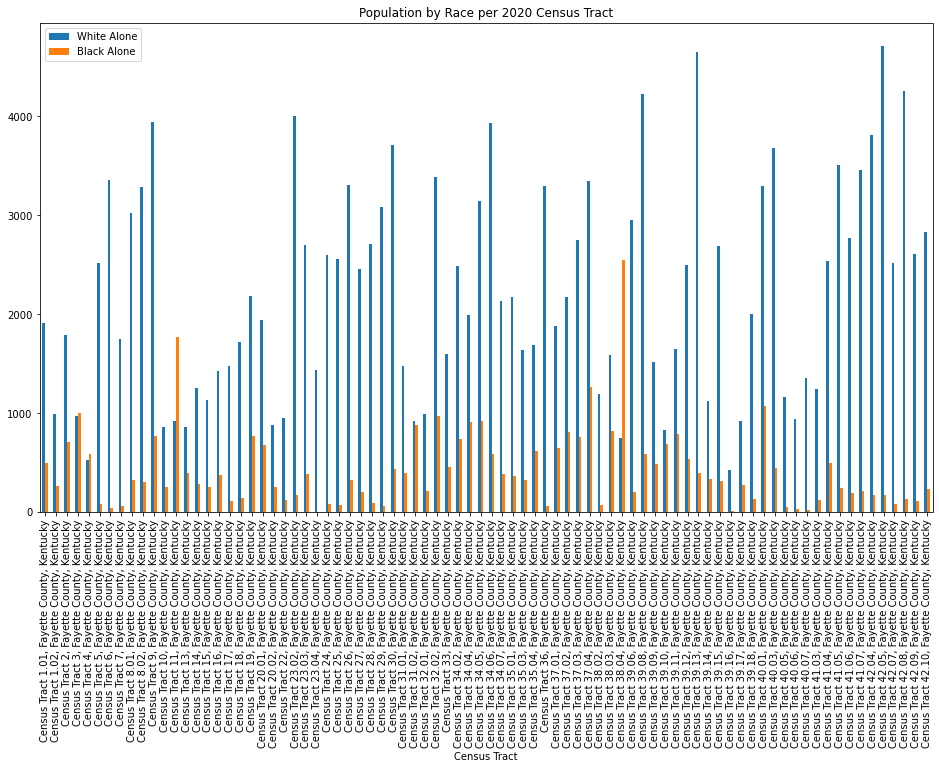

In [16]:
#double bar graph to plot race by tract
race_bw_df.plot(y=['White Alone','Black Alone'],
                x='Census Tract',
                kind='bar',
                figsize=(16,9),
                title='Population by Race per 2020 Census Tract');

plt.show()

Need to add geolocation for the census tracts. Then map and clip only those tracts within New Circle

<a id='cbtract'></a>
## Census Bureau Tract Data 2019
Examine the Census Bureau Shapefile Census tracts.

In [17]:
#Import necessary packages
%matplotlib inline
import pandas as pd
import geopandas as gpd

In [18]:
# import data & confirm GeoPandas works
cb_tracts_2019_ky_gdf = gpd.read_file('./data/cb_2019_tract_500k/cb_2019_21_tract_500k.shp')
cb_tracts_2019_ky_gdf.head() 

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,089,040502,1400000US21089040502,21089040502,405.02,CT,248542928,4123331,"POLYGON ((-83.05044 38.46728, -83.04835 38.467..."
1,21,087,930100,1400000US21087930100,21087930100,9301,CT,253771498,2116317,"POLYGON ((-85.69732 37.30184, -85.68857 37.352..."
2,21,111,012601,1400000US21111012601,21111012601,126.01,CT,4460299,5315,"POLYGON ((-85.84257 38.19537, -85.83500 38.201..."
3,21,111,012302,1400000US21111012302,21111012302,123.02,CT,4811351,28216,"POLYGON ((-85.82930 38.15719, -85.82586 38.162..."
4,21,099,970300,1400000US21099970300,21099970300,9703,CT,256953396,5843968,"POLYGON ((-86.16112 37.35080, -86.15845 37.351..."


Determine Data types

In [19]:
# determine data types working with
cb_tracts_2019_ky_gdf.info() #currently 1115 entries

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1115 non-null   object  
 1   COUNTYFP  1115 non-null   object  
 2   TRACTCE   1115 non-null   object  
 3   AFFGEOID  1115 non-null   object  
 4   GEOID     1115 non-null   object  
 5   NAME      1115 non-null   object  
 6   LSAD      1115 non-null   object  
 7   ALAND     1115 non-null   int64   
 8   AWATER    1115 non-null   int64   
 9   geometry  1115 non-null   geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 87.2+ KB


Drop all Tracts whose COUNTYFP does not equal Fayette County (i.e. 067). Currently contains ALL Kentucky tracts.

In [20]:
# convert STATEFP from object to string
cb_tracts_2019_ky_gdf['COUNTYFP']=cb_tracts_2019_ky_gdf['COUNTYFP'].astype(str)
# example race_bw_df['Total']=race_bw_df['Total'].astype(float)

# assign and pull out all rows associated with KY (21)
cb_tracts_2019_fayette_gdf = cb_tracts_2019_ky_gdf[cb_tracts_2019_ky_gdf.COUNTYFP == '067']

In [21]:
# confirm creation of new geodataframe with KY only data
cb_tracts_2019_fayette_gdf.info() #now only 82 entries which matches the number of entries in pandas dataframe above

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82 entries, 23 to 1112
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   82 non-null     object  
 1   COUNTYFP  82 non-null     object  
 2   TRACTCE   82 non-null     object  
 3   AFFGEOID  82 non-null     object  
 4   GEOID     82 non-null     object  
 5   NAME      82 non-null     object  
 6   LSAD      82 non-null     object  
 7   ALAND     82 non-null     int64   
 8   AWATER    82 non-null     int64   
 9   geometry  82 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 7.0+ KB


Glimpse headers of Fayette County Census Tracts

In [22]:
# review headers 
cb_tracts_2019_fayette_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
23,21,067,001500,1400000US21067001500,21067001500,15,CT,1968316,0,"POLYGON ((-84.47247 38.05277, -84.47135 38.053..."
26,21,067,003202,1400000US21067003202,21067003202,32.02,CT,3028160,0,"POLYGON ((-84.46479 38.06010, -84.45494 38.063..."
30,21,067,003914,1400000US21067003914,21067003914,39.14,CT,1340775,0,"POLYGON ((-84.41176 38.02212, -84.40621 38.025..."
31,21,067,001900,1400000US21067001900,21067001900,19,CT,2300743,0,"POLYGON ((-84.54345 38.04757, -84.54265 38.047..."
43,21,067,003201,1400000US21067003201,21067003201,32.01,CT,1982605,0,"POLYGON ((-84.47185 38.06696, -84.46873 38.067..."


Won't need all attributes. Drop those not necessary for project completion.

In [23]:
# drop excess columns 

# To Drop Columns state fips code, county fips code, area water, legal statistical area description (census tract)
to_drop = ['STATEFP', 'COUNTYFP', 'AWATER', 'LSAD']

# drop excess columns from geodataframe
# assign remaining data to new dataframe name
cb_tracts_2019_fayette_gdf_min = cb_tracts_2019_fayette_gdf.drop(to_drop, axis=1)

In [24]:
#confirm drop
cb_tracts_2019_fayette_gdf_min.head()

,TRACTCE,AFFGEOID,GEOID,NAME,ALAND,geometry
23,001500,1400000US21067001500,21067001500,15,1968316,"POLYGON ((-84.47247 38.05277, -84.47135 38.053..."
26,003202,1400000US21067003202,21067003202,32.02,3028160,"POLYGON ((-84.46479 38.06010, -84.45494 38.063..."
30,003914,1400000US21067003914,21067003914,39.14,1340775,"POLYGON ((-84.41176 38.02212, -84.40621 38.025..."
31,001900,1400000US21067001900,21067001900,19,2300743,"POLYGON ((-84.54345 38.04757, -84.54265 38.047..."
43,003201,1400000US21067003201,21067003201,32.01,1982605,"POLYGON ((-84.47185 38.06696, -84.46873 38.067..."


<a id='mergeRaceTract'></a>
## Merge Race/Segregation Data & Census Bureau Tract Data

In [25]:
#rename AFFGEOID to GEO_ID so can merge with race_bw_df
cb_tracts_2019_fayette_gdf_min.rename(columns={'AFFGEOID':'GEO_ID'}, inplace=True)

In [26]:
#confirm column name change
cb_tracts_2019_fayette_gdf_min.head()

,TRACTCE,GEO_ID,GEOID,NAME,ALAND,geometry
23,001500,1400000US21067001500,21067001500,15,1968316,"POLYGON ((-84.47247 38.05277, -84.47135 38.053..."
26,003202,1400000US21067003202,21067003202,32.02,3028160,"POLYGON ((-84.46479 38.06010, -84.45494 38.063..."
30,003914,1400000US21067003914,21067003914,39.14,1340775,"POLYGON ((-84.41176 38.02212, -84.40621 38.025..."
31,001900,1400000US21067001900,21067001900,19,2300743,"POLYGON ((-84.54345 38.04757, -84.54265 38.047..."
43,003201,1400000US21067003201,21067003201,32.01,1982605,"POLYGON ((-84.47185 38.06696, -84.46873 38.067..."


Merge pandas dataframe for census data by race with geopandas dataframe of census bureau tracts using GEO_ID in pandas dataframe and GEOID in geopandas dataframe.

In [27]:
#race_bw_df merge with cb_tracts_2019_fayette_gdf_min
race_cb_tracts_2019_gdf = cb_tracts_2019_fayette_gdf_min.merge(race_bw_df, on = 'GEO_ID')

In [28]:
#confirm merge by entries
race_cb_tracts_2019_gdf.head()
race_cb_tracts_2019_gdf.info() #82 entries available just like in race_bw_df 7.0KB

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82 entries, 0 to 81
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   TRACTCE       82 non-null     object  
 1   GEO_ID        82 non-null     object  
 2   GEOID         82 non-null     object  
 3   NAME          82 non-null     object  
 4   ALAND         82 non-null     int64   
 5   geometry      82 non-null     geometry
 6   Census Tract  82 non-null     object  
 7   Total         82 non-null     float64 
 8   White Alone   82 non-null     float64 
 9   Black Alone   82 non-null     float64 
dtypes: float64(3), geometry(1), int64(1), object(5)
memory usage: 7.0+ KB


In [29]:
#glimpse headers
race_cb_tracts_2019_gdf.head(5)

,TRACTCE,GEO_ID,GEOID,NAME,ALAND,geometry,Census Tract,Total,White Alone,Black Alone
0,001500,1400000US21067001500,21067001500,15,1968316,"POLYGON ((-84.47247 38.05277, -84.47135 38.053...","Census Tract 15, Fayette County, Kentucky",1651.0,1131.0,252.0
1,003202,1400000US21067003202,21067003202,32.02,3028160,"POLYGON ((-84.46479 38.06010, -84.45494 38.063...","Census Tract 32.02, Fayette County, Kentucky",5084.0,3386.0,973.0
2,003914,1400000US21067003914,21067003914,39.14,1340775,"POLYGON ((-84.41176 38.02212, -84.40621 38.025...","Census Tract 39.14, Fayette County, Kentucky",1750.0,1124.0,333.0
3,001900,1400000US21067001900,21067001900,19,2300743,"POLYGON ((-84.54345 38.04757, -84.54265 38.047...","Census Tract 19, Fayette County, Kentucky",3818.0,2189.0,767.0
4,003201,1400000US21067003201,21067003201,32.01,1982605,"POLYGON ((-84.47185 38.06696, -84.46873 38.067...","Census Tract 32.01, Fayette County, Kentucky",1348.0,990.0,214.0


<a id='mapRaceTract'></a>
### Map Race/Segregation Data

In [30]:
# determine epsg for gdf
print('Race Census Bureau Tracts CRS=', race_cb_tracts_2019_gdf.crs)

Race Census Bureau Tracts CRS= epsg:4269


CRS 4269 utilizes unit in degrees. Need to transform to 2205 for meters (geopandas/shapely assume their set of operations are being used in meters).

In [31]:
#convert epsg 4269 to epsg 2205
crs = {'init' : 'epsg:2205'}
race_tracts_2019_geo = race_cb_tracts_2019_gdf.to_crs(crs)

C:\Users\jbra2\.conda\envs\ukthesis2\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [32]:
# confirm conversion
print('Race Census Bureau Tracts CRS=', race_tracts_2019_geo.crs)

Race Census Bureau Tracts CRS= +init=epsg:2205 +type=crs


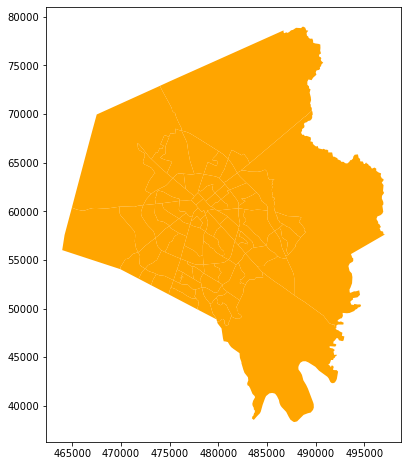

In [128]:
# plot all census tracts for fayette county
fig, ax = plt.subplots(figsize=(12, 8))

race_tracts_2019_geo.plot(ax=ax, color='orange', zorder=0,);

Confirm unique values named using new CRS geo layer

In [34]:
print(race_tracts_2019_geo['NAME'].unique())
print(race_tracts_2019_geo['NAME'].count())

['15' '32.02' '39.14' '19' '32.01' '29' '40.01' '20.02' '31.01' '11'
 '42.09' '33' '4' '39.11' '40.03' '41.03' '39.10' '7' '28' '41.07' '22'
 '16' '42.04' '8.01' '13' '2' '35.01' '42.08' '34.02' '39.08' '39.13' '9'
 '41.04' '24' '18' '5' '41.05' '1.02' '34.04' '27' '38.03' '38.04' '23.02'
 '35.04' '42.05' '40.06' '36' '25' '35.03' '39.17' '40.07' '23.03' '42.10'
 '8.02' '38.02' '37.02' '1.01' '40.05' '41.06' '17' '34.07' '39.12'
 '39.09' '34.05' '39.16' '6' '34.06' '37.03' '31.02' '42.07' '23.04'
 '37.04' '20.01' '14' '30' '10' '39.18' '39.15' '3' '37.01' '26' '39.06']
82


Need to clip to census tracts within new circle road of Lexington to reduce file size and limit area of interest to those necessary for HOLC graded neighborhoods. Best plan of action is to create a shapefile for new circle road using qgis then load to notebook for clipping purposes.

<a id='newCircle'></a>
#### Clipping to New Circle

Load qgis created New Circle Shapefile

In [35]:
# import data & confirm GeoPandas works
new_circle_gdf = gpd.read_file('./data/new_circle/new_circle_road.shp')
new_circle_gdf.head() 

,id,geometry
0,1,"POLYGON ((-84.55734 38.02482, -84.55984 38.026..."


In [36]:
# view data types
new_circle_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        1 non-null      int64   
 1   geometry  1 non-null      geometry
dtypes: geometry(1), int64(1)
memory usage: 144.0 bytes


View New Circle CRS

In [37]:
print('New Circle CRS=', new_circle_gdf.crs)

New Circle CRS= epsg:4326


Convert CRS from 4326 to 2205 to matche race/census tracts CRS for plotting

In [38]:
#convert crs
crs = {'init' : 'epsg:2205'}
new_circle_geo = new_circle_gdf.to_crs(crs)


C:\Users\jbra2\.conda\envs\ukthesis2\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [39]:
print('New Circle CRS=', new_circle_geo.crs)

New Circle CRS= +init=epsg:2205 +type=crs


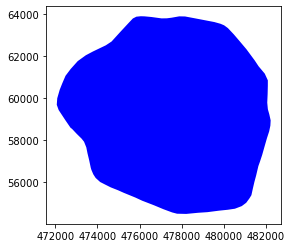

In [40]:
fig, ax = plt.subplots()
new_circle_geo.plot(ax=ax, color='blue', zorder=0,);

Plot both inside New Circle Road and Census Tracts to see how much data will be reduced when clipping to New Circle Road.

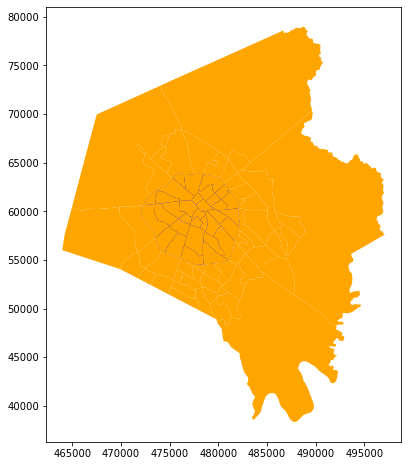

In [129]:
#Plot both new circle and census tracts
fig, ax = plt.subplots(figsize=(12, 8))
new_circle_geo.plot(ax=ax, color='blue', zorder=0,);
race_tracts_2019_geo.plot(ax=ax, color='orange', zorder=1,);

In [62]:
# Double check new_circle_geo only has one polygon type (either polygon or multiplogyon types not both)
new_circle_geo.geom_type.unique()

array(['Polygon'], dtype=object)

In [63]:
# use unary_union to combine polygon into single polygon mask to clip by
new_circle_geo_poly = new_circle_geo.geometry.unary_union

In [64]:
#using new circle poly layer, clip each census tract 
new_circle_race_tracts = race_tracts_2019_geo[race_tracts_2019_geo.intersects(new_circle_geo_poly)]

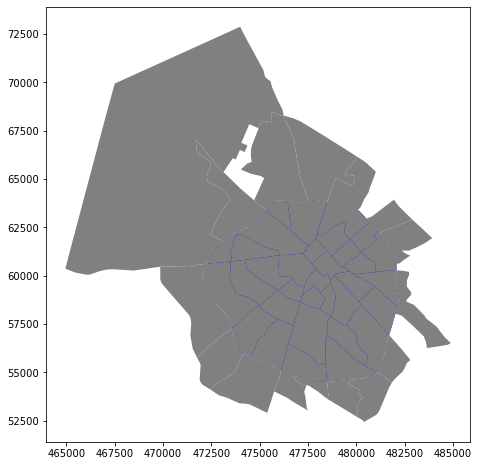

In [130]:
#Plot both new circle and newly clipped tracts
fig, ax = plt.subplots(figsize=(12, 8))
new_circle_geo.plot(ax=ax, color='blue', zorder=0,);
new_circle_race_tracts.plot(ax=ax, color='grey', zorder=1,);

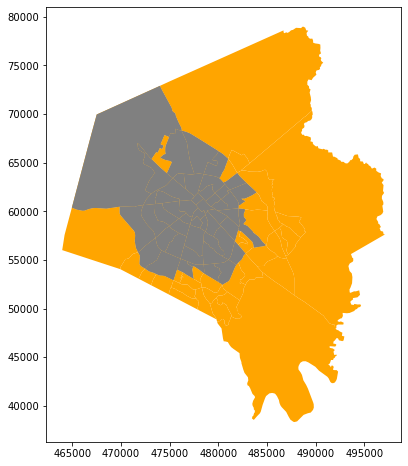

In [131]:
#Plot both old and new census tracts to confirm clip accuracy
fig, ax = plt.subplots(figsize=(12, 8))
race_tracts_2019_geo.plot(ax=ax, color='orange', zorder=0,); 
new_circle_race_tracts.plot(ax=ax, color='grey', zorder=1,);

Still pulling more area than prefer, but may still need to keep the outside areas as they are tracts that do intersect with new circle. Another thought is to clip this further with only the HOLC graded neighborhoods...caveat here is would end up missing unique interpretations that could be made about surrounding neighborhoods that grew up after HOLC grading.

In [68]:
# glimpse merged/clipped geopandas dataframe
new_circle_race_tracts.info() #race tracts reduced from 82 entries to 49 and 4.2KB

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49 entries, 0 to 80
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   TRACTCE       49 non-null     object  
 1   GEO_ID        49 non-null     object  
 2   GEOID         49 non-null     object  
 3   NAME          49 non-null     object  
 4   ALAND         49 non-null     int64   
 5   geometry      49 non-null     geometry
 6   Census Tract  49 non-null     object  
 7   Total         49 non-null     float64 
 8   White Alone   49 non-null     float64 
 9   Black Alone   49 non-null     float64 
dtypes: float64(3), geometry(1), int64(1), object(5)
memory usage: 4.2+ KB


In [70]:
new_circle_race_tracts.head()

,TRACTCE,GEO_ID,GEOID,NAME,ALAND,geometry,Census Tract,Total,White Alone,Black Alone
0,001500,1400000US21067001500,21067001500,15,1968316,"POLYGON ((480474.524 61378.770, 480572.928 614...","Census Tract 15, Fayette County, Kentucky",1651.0,1131.0,252.0
1,003202,1400000US21067003202,21067003202,32.02,3028160,"POLYGON ((481149.868 62191.215, 482015.597 625...","Census Tract 32.02, Fayette County, Kentucky",5084.0,3386.0,973.0
3,001900,1400000US21067001900,21067001900,19,2300743,"POLYGON ((474242.468 60819.375, 474312.809 608...","Census Tract 19, Fayette County, Kentucky",3818.0,2189.0,767.0
4,003201,1400000US21067003201,21067003201,32.01,1982605,"POLYGON ((480532.121 62954.227, 480806.698 630...","Census Tract 32.01, Fayette County, Kentucky",1348.0,990.0,214.0
5,002900,1400000US21067002900,21067002900,29,3179556,"POLYGON ((473557.126 57277.354, 473740.056 574...","Census Tract 29, Fayette County, Kentucky",3363.0,3085.0,59.0


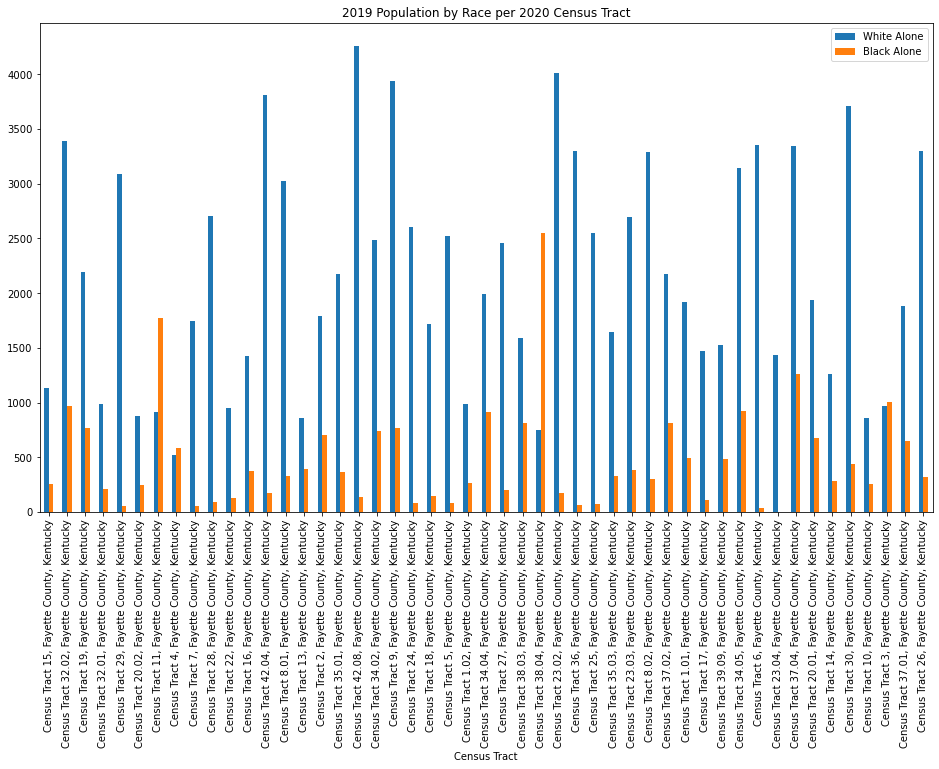

In [72]:
#double bar graph to plot race by clipped tracts
new_circle_race_tracts.plot(y=['White Alone','Black Alone'],
                x='Census Tract',
                kind='bar',
                figsize=(16,9),
                title='2020 Population by Race per Census Tract');

plt.show()

Pick back up by attempting to clip to the HOLC graded neighborhoods to see how much would be lost and if larger picture would still be available. Could always add buffer to clip by, but would most likely end up with the same tracts as is currently pictured in new_circle_race_tracts.

Still to do:
*Open the home mortgage disclosure act to explore what attributes are within.     
*Overlay census tracts with redlining geoJSON to determine what tracts to pull (quick viz from past QGIS lex_parks project)  
*Find HOLC descriptions for individual grade blocks example D3 or D4 and the exact quote text they use to describe that block
*With every data download from Lexingtons Data portal need to pull the terms of use.  

<a id='clipHOLC'></a>
#### Clip by HOLC neighborhoods

In [ ]:
# import data & confirm GeoPandas works
holc_gdf = gpd.read_file('./data/KYLexington1936.geojson')

In [76]:
holc_gdf.head()

,name,holc_id,holc_grade,area_description_data,geometry
0,None,A1,A,{'': ''},"MULTIPOLYGON (((-84.51133 38.01811, -84.51211 ..."
1,None,A2,A,{'': ''},"MULTIPOLYGON (((-84.49628 38.02381, -84.49376 ..."
2,None,A3,A,{'': ''},"MULTIPOLYGON (((-84.47662 38.02922, -84.47708 ..."
3,None,A4,A,{'': ''},"MULTIPOLYGON (((-84.47662 38.02922, -84.47470 ..."
4,None,B1,B,{'': ''},"MULTIPOLYGON (((-84.51276 38.03197, -84.50941 ..."


In [77]:
holc_gdf.info() #29 entries; 4 objects 1 geometry 1.3 KB

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   name                   0 non-null      object  
 1   holc_id                29 non-null     object  
 2   holc_grade             29 non-null     object  
 3   area_description_data  29 non-null     object  
 4   geometry               29 non-null     geometry
dtypes: geometry(1), object(4)
memory usage: 1.3+ KB


In [78]:
print('HOLC CRS=', holc_gdf.crs)

HOLC CRS= epsg:4326


In [79]:
#convert crs to 2205
crs = {'init' : 'epsg:2205'}
holc_geo = holc_gdf.to_crs(crs)

C:\Users\jbra2\.conda\envs\ukthesis2\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [80]:
print('HOLC CRS=', holc_geo.crs)

HOLC CRS= +init=epsg:2205 +type=crs


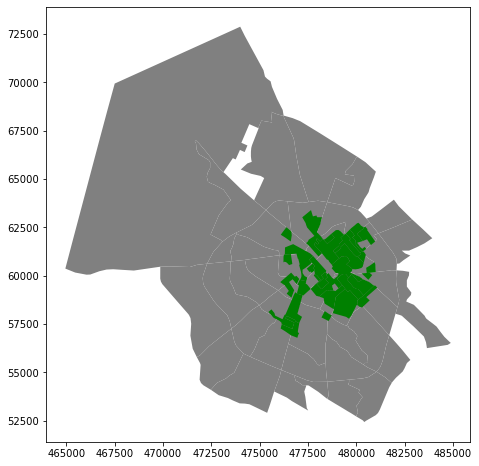

In [132]:
# plot holc and clipped tracts to see if can reduce further
fig, ax = plt.subplots(figsize=(12, 8))
holc_geo.plot(ax=ax, color='green', zorder=1,);
new_circle_race_tracts.plot(ax=ax, color='grey', zorder=0,);

Much fewer tracts will be selected this way, however, it will still include surrounding areas. Will proceed with this method.

In [85]:
# Double check holc only has one polygon type (either polygon or multiplogyon types not both)
holc_geo.geom_type.unique() # only one polygon type, MultiPolygon

array(['MultiPolygon'], dtype=object)

In [86]:
# use unary_union to combine Multipolygon into single polygon mask to clip by
holc_geo_poly = holc_geo.geometry.unary_union

In [87]:
#using new holc_geo_poly layer, clip each census tract from previous new circl clip
holc_race_tracts = new_circle_race_tracts[new_circle_race_tracts.intersects(holc_geo_poly)]

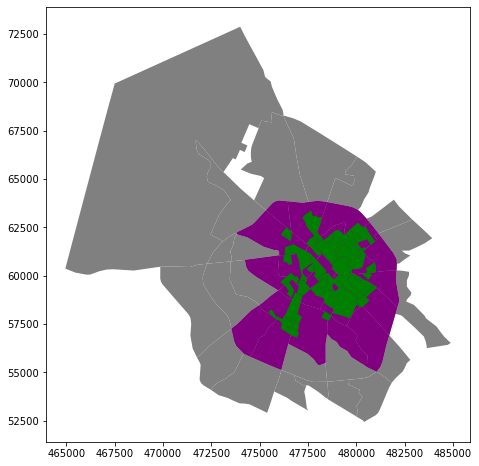

In [133]:
# plot holc newly clipped race tracts
fig, ax = plt.subplots(figsize=(12, 8))
holc_race_tracts.plot(ax=ax, color='purple', zorder=1);
new_circle_race_tracts.plot(ax=ax, color='grey', zorder=0,);
holc_geo.plot(ax=ax, color='green', zorder=2,);

Have significantly reduced the number of tracts. Lets look into the info and headers now.

In [99]:
holc_race_tracts.info() #reduced from 82 to 49 to now 27; and 7.0KB to 4.2KB to now 2.3KB

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 27 entries, 0 to 78
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   TRACTCE       27 non-null     object  
 1   GEO_ID        27 non-null     object  
 2   GEOID         27 non-null     object  
 3   NAME          27 non-null     object  
 4   ALAND         27 non-null     int64   
 5   geometry      27 non-null     geometry
 6   Census Tract  27 non-null     object  
 7   Total         27 non-null     float64 
 8   White Alone   27 non-null     float64 
 9   Black Alone   27 non-null     float64 
dtypes: float64(3), geometry(1), int64(1), object(5)
memory usage: 2.3+ KB


In [105]:
holc_race_tracts.head()

,TRACTCE,GEO_ID,GEOID,NAME,ALAND,geometry,Census Tract,Total,White Alone,Black Alone
0,001500,1400000US21067001500,21067001500,15,1968316,"POLYGON ((480474.524 61378.770, 480572.928 614...","Census Tract 15, Fayette County, Kentucky",1651.0,1131.0,252.0
3,001900,1400000US21067001900,21067001900,19,2300743,"POLYGON ((474242.468 60819.375, 474312.809 608...","Census Tract 19, Fayette County, Kentucky",3818.0,2189.0,767.0
5,002900,1400000US21067002900,21067002900,29,3179556,"POLYGON ((473557.126 57277.354, 473740.056 574...","Census Tract 29, Fayette County, Kentucky",3363.0,3085.0,59.0
9,001100,1400000US21067001100,21067001100,11,3165953,"POLYGON ((476452.701 63851.280, 477230.313 637...","Census Tract 11, Fayette County, Kentucky",3787.0,918.0,1774.0
12,000400,1400000US21067000400,21067000400,4,1185662,"POLYGON ((479310.644 60460.838, 479764.128 609...","Census Tract 4, Fayette County, Kentucky",1288.0,524.0,587.0


In [113]:
print('HOLC Census Tracts of Interest:', holc_race_tracts['NAME'].unique())
print('Total HOLC Census Tracts of Interest:', holc_race_tracts['NAME'].count())

HOLC Census Tracts of Interest: ['15' '19' '29' '11' '4' '7' '28' '22' '16' '8.01' '13' '2' '9' '24' '18'
 '5' '1.02' '25' '23.03' '8.02' '1.01' '17' '6' '23.04' '14' '10' '3']
Total HOLC Census Tracts of Interest: 27


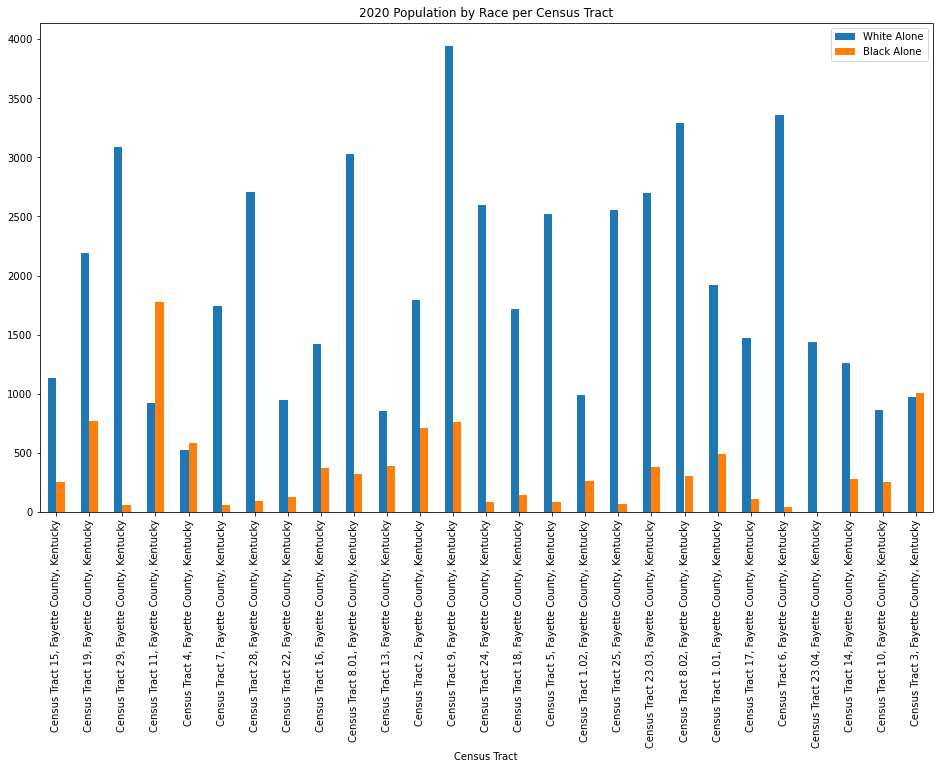

In [114]:
#double bar graph to plot race by clipped tracts
holc_race_tracts.plot(y=['White Alone','Black Alone'],
                x='Census Tract',
                kind='bar',
                figsize=(16,9),
                title='2020 Population by Race per Census Tract');

plt.show()